In [1]:
# 1. Imports
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import optuna

# modeling
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from scipy.special import logit, expit
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit

# PyTorch for conversion model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# nfl pbp loader
import nfl_data_py as nfl

# reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# 2a. Download PBP (this can take a few minutes)
seasons = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]
print("Loading play-by-play for seasons:", seasons)
raw_pbp = nfl.import_pbp_data(seasons, downcast=False)  # returns a DataFrame (may be large)

print("Rows loaded:", raw_pbp.shape[0])
raw_pbp.head()

Loading play-by-play for seasons: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2024 done.
Rows loaded: 433940


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,was_pressure,route,defense_man_zone_type,defense_coverage_type,offense_names,defense_names,offense_positions,defense_positions,offense_numbers,defense_numbers
0,1.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,96.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def parse_weather(weather_str):
    """
    Parses a weather string into structured features:
        - temp_F: float
        - humidity: float (percentage)
        - wind_mph: float
        - wind_dir: str
        - conditions: str (general description, e.g., 'sunny', 'cloudy', etc.)
    """
    result = {
        "temp_F": None,
        "humidity": None,
        "wind_mph": None,
        "wind_dir": None,
        "conditions": None
    }
    
    if not isinstance(weather_str, str):
        return result
    
    lower_str = weather_str.lower()
    
    # Extract temperature
    temp_match = re.search(r'(\d+)\s*°?\s*f', lower_str)
    if temp_match:
        result['temp_F'] = float(temp_match.group(1))
    
    # Extract humidity
    hum_match = re.search(r'humidity[:\s]*(\d+)%', lower_str)
    if hum_match:
        result['humidity'] = float(hum_match.group(1))
    
    # Extract wind speed and direction
    wind_match = re.search(r'wind[:\s]*([nesw]+)\s*(\d+)\s*mph', lower_str)
    if wind_match:
        result['wind_dir'] = wind_match.group(1).upper()
        result['wind_mph'] = float(wind_match.group(2))
    
    # Extract general conditions
    conditions = []
    for cond in ['sunny', 'cloudy', 'clear', 'rain', 'snow', 'fog', 'drizzle', 'storm', 'windy']:
        if cond in lower_str:
            conditions.append(cond)
    if conditions:
        result['conditions'] = ','.join(conditions)
    
    return result


def deconstruct_weather(df, weather_col='weather'):
    """
    Adds structured weather columns to a DataFrame based on a weather string column.
    
    New columns added:
      - temp_F
      - humidity
      - wind_mph
      - wind_dir
      - conditions
    """
    weather_data = df[weather_col].apply(parse_weather)
    weather_df = pd.DataFrame(weather_data.tolist())
    df = pd.concat([df.reset_index(drop=True), weather_df], axis=1)
    
    # Fill missing wind speeds with 0
    df['wind_mph'] = df['wind_mph'].fillna(0)

    # Fill missing temperatures with 60°F
    df['temp_F'] = df['temp_F'].fillna(60)

    return df

In [4]:
pbp = raw_pbp.copy()
pbp = deconstruct_weather(pbp)
pbp = pbp[pbp.penalty == 0]

In [5]:
def make_temporal_folds(df, season_col="season", min_train_seasons=3):
    """
    Expanding-window CV folds by season.
    Returns list of (train_idx, val_idx).
    """
    seasons = np.sort(df[season_col].unique())
    folds = []

    for i in range(min_train_seasons, len(seasons)):
        train_seasons = seasons[:i]
        val_season = seasons[i]

        train_idx = df[df[season_col].isin(train_seasons)].index
        val_idx = df[df[season_col] == val_season].index

        folds.append((train_idx, val_idx))

    return folds

In [6]:
# --- Drop rows missing home/away WP ---
wp_df = pbp.dropna(subset=["home_wp_post", "away_wp_post"]).copy()

# --- Define features ---
wp_df["score_time_ratio"] = wp_df["score_differential"].abs() / (wp_df["game_seconds_remaining"] + 1)
wp_features = [
    "yardline_100",
    "down",
    "ydstogo",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

# --- Define posteam WP target ---
wp_df["wp_target"] = np.where(
    wp_df["posteam"] == wp_df["home_team"],
    wp_df["home_wp_post"],
    wp_df["away_wp_post"]
)

wp_df = wp_df.reset_index(drop=True)

X_wp = wp_df[wp_features]
y_wp = wp_df["wp_target"]

# --- Clip target to avoid exact 0/1 ---
epsilon = 1e-6
y_wp_clipped = y_wp.clip(epsilon, 1 - epsilon).reset_index(drop=True)

# --- Monotone constraints (time variables unconstrained now) ---
monotone_constraints_dict = {
    "yardline_100": -1,               # closer to opponent endzone → WP ↑
    "down": -1,                       # higher down (worse) → WP ↓
    "ydstogo": -1,                    # more yards to go → WP ↓
    "score_differential": 1,          # lead → WP ↑
    "posteam_timeouts_remaining": 1,  # more TOs → WP ↑
    "defteam_timeouts_remaining": -1  # opponent TOs → WP ↓
}

wp_folds = make_temporal_folds(wp_df)

In [7]:
def wp_objective(trial):

    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 5),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.08),
        "n_estimators": trial.suggest_int("n_estimators", 200, 400),
        "subsample": trial.suggest_float("subsample", 0.7, 0.9),
        "min_child_weight": trial.suggest_int("min_child_weight", 20, 100),
        "verbosity": 0,
        "monotone_constraints": monotone_constraints_dict,
    }

    rmses = []

    for train_idx, val_idx in wp_folds:
        X_train, X_val = X_wp.iloc[train_idx], X_wp.iloc[val_idx]
        y_train, y_val = y_wp_clipped.iloc[train_idx], y_wp_clipped.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            early_stopping_rounds=10,
            verbose=False
        )

        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds, squared=False)
        rmses.append(rmse)

    return np.mean(rmses)

In [8]:
wp_study = optuna.create_study(direction="minimize")
wp_study.optimize(wp_objective, n_trials=10)

[I 2025-12-30 11:34:45,873] A new study created in memory with name: no-name-d4d89abc-8695-4111-bc28-a0be725b7965
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for be

C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

In [9]:
best_params = wp_study.best_params
best_score = wp_study.best_value

print("Best CV RMSE:", best_score)
print("Best params:", best_params)

Best CV RMSE: 0.05940726894723742
Best params: {'max_depth': 5, 'learning_rate': 0.07151396073841006, 'n_estimators': 237, 'subsample': 0.7906051210627808, 'min_child_weight': 66}


In [10]:
# Add monotone constraints if not in params already
best_params["monotone_constraints"] = monotone_constraints_dict
best_params["verbosity"] = 0

wp_model = XGBRegressor(**best_params)
wp_model.fit(X_wp, y_wp_clipped)  # Train on full dataset


def predict_wp(state_df):
    """
    Returns win probability for the team with possession in state_df.
    All EWPs are reported from the perspective of the pre-play offensive team.
    Therefore:
        - Use predict_wp(...) if possession is retained
        - Use 1 - predict_wp(...) if possession flips
    """
    
    if "score_time_ratio" not in state_df:
        state_df["score_time_ratio"] = state_df["score_differential"].abs() / (state_df["game_seconds_remaining"] + 1)
    preds = wp_model.predict(state_df[wp_features])
    return np.clip(preds, 0.0, 1.0)

In [11]:
def flip_possession(state):
    """
    Flip possession for WP prediction.
    Returns a new state dict from the perspective of the new posteam.
    """
    new_state = state.copy()
    # Negate score differential
    new_state["score_differential"] = -state["score_differential"]
    # Swap timeouts
    new_state["posteam_timeouts_remaining"] = state["defteam_timeouts_remaining"]
    new_state["defteam_timeouts_remaining"] = state["posteam_timeouts_remaining"]
       
    return new_state

In [12]:
# Create punt_df with only punt plays
punt_df = pbp[pbp.play_type == "punt"].dropna(subset=["kick_distance", "return_yards"]).copy()

# Compute net punt yardage: kick distance minus return yards, adjust for touchbacks (if available)
# Assuming touchback puts ball at 20-yard line
punt_df["net_punt"] = punt_df["kick_distance"] - punt_df["return_yards"]
punt_df.loc[punt_df["touchback"] == 1, "net_punt"] = punt_df["yardline_100"] - 20

# Reset index to avoid any issues
punt_df = punt_df.reset_index(drop=True)

# Make temporal folds based on seasons in punt_df
punt_folds = make_temporal_folds(punt_df, season_col="season", min_train_seasons=3)

# Features to predict net punt
punt_df["score_time_ratio"] = punt_df["score_differential"].abs() / (punt_df["game_seconds_remaining"] + 1)
punt_features = [
    "yardline_100", 
    "game_seconds_remaining", 
    "half_seconds_remaining",
    "score_differential",
    "score_time_ratio",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "temp_F",
    "wind_mph"
]

X_punt = punt_df[punt_features].values
y_punt = punt_df["net_punt"].values

X_scaler = StandardScaler()
X_punt_scaled = X_scaler.fit_transform(X_punt)

y_scaler = StandardScaler()
y_punt_scaled = y_scaler.fit_transform(y_punt.reshape(-1,1))

In [13]:
def punt_objective(trial):
    # Suggest hyperparameters
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)
    epochs = 50  # you can tune this later

    rmses = []

    # Loop over temporal folds
    for train_idx, val_idx in punt_folds:
        # Prepare fold data
        X_train = torch.tensor(X_punt_scaled[train_idx], dtype=torch.float32)
        y_train = torch.tensor(y_punt_scaled[train_idx], dtype=torch.float32)
        X_val = torch.tensor(X_punt_scaled[val_idx], dtype=torch.float32)
        y_val = torch.tensor(y_punt_scaled[val_idx], dtype=torch.float32)

        input_dim = X_train.shape[1]

        # Build the network
        layers = []
        for i in range(n_layers):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_size, 1))
        # For regression, remove Sigmoid. Keep raw output
        model = nn.Sequential(*layers)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training loop
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val).item()
            rmses.append(np.sqrt(val_loss))  # RMSE for consistency

    # Return mean RMSE across folds
    return np.mean(rmses)

In [14]:
punt_study = optuna.create_study(direction="minimize")
punt_study.optimize(punt_objective, n_trials=10)

[I 2025-12-30 11:38:51,373] A new study created in memory with name: no-name-6fc17c05-9036-470b-9f3a-95931f0cd2eb
[I 2025-12-30 11:38:54,952] Trial 0 finished with value: 0.9170904129946145 and parameters: {'n_layers': 2, 'hidden_size': 51, 'lr': 0.002816364611223716, 'dropout': 0.20901648990302363}. Best is trial 0 with value: 0.9170904129946145.
[I 2025-12-30 11:38:57,886] Trial 1 finished with value: 0.9434311479779001 and parameters: {'n_layers': 1, 'hidden_size': 115, 'lr': 0.0007503846604904576, 'dropout': 0.28414087987597}. Best is trial 0 with value: 0.9170904129946145.
[I 2025-12-30 11:39:07,609] Trial 2 finished with value: 0.917459913296233 and parameters: {'n_layers': 3, 'hidden_size': 109, 'lr': 0.0005550226230138362, 'dropout': 0.005087165078868416}. Best is trial 0 with value: 0.9170904129946145.
[I 2025-12-30 11:39:15,874] Trial 3 finished with value: 0.9168274637297479 and parameters: {'n_layers': 2, 'hidden_size': 115, 'lr': 0.0014615710946895865, 'dropout': 0.0889654

In [15]:
best_params = punt_study.best_params
best_score = punt_study.best_value
n_layers = best_params["n_layers"]
hidden_size = best_params["hidden_size"]
dropout_rate = best_params["dropout"]
lr = best_params["lr"]

print("Best CV RMSE:", best_score)
print("Best params:", best_params)

Best CV RMSE: 0.9161157323740197
Best params: {'n_layers': 3, 'hidden_size': 42, 'lr': 0.006302108626157786, 'dropout': 0.15536928998600635}


In [16]:
# Build final model
layers = []
input_dim = X_punt_scaled.shape[1]
for i in range(n_layers):
    layers.append(nn.Linear(input_dim if i==0 else hidden_size, hidden_size))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout_rate))
layers.append(nn.Linear(hidden_size, 1))
punt_model = nn.Sequential(*layers)

# Convert full data to tensors
X_t = torch.tensor(X_punt_scaled, dtype=torch.float32)
y_t = torch.tensor(y_punt_scaled, dtype=torch.float32)

optimizer = torch.optim.Adam(punt_model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# Train final model
epochs = 1000  # or tune
for epoch in range(epochs):
    optimizer.zero_grad()
    preds = punt_model(X_t)
    loss = loss_fn(preds, y_t)
    loss.backward()
    optimizer.step()

In [17]:
def predict_punt(state_dict):
    """
    state_dict can be a DataFrame (multiple rows) or a Series (single row)
    """
    # Ensure 2D input
    if isinstance(state_dict, pd.Series):
        state_df = pd.DataFrame([state_dict])
    else:
        state_df = state_dict

    x_scaled = X_scaler.transform(state_df[punt_features])
    x_t = torch.tensor(x_scaled, dtype=torch.float32)

    with torch.no_grad():
        y_scaled_pred = punt_model(x_t).numpy().ravel()  # works for batch or single row

    net_punt = y_scaler.inverse_transform(y_scaled_pred.reshape(-1, 1)).ravel()

    # Return scalar if single row, else array
    if len(net_punt) == 1:
        return net_punt[0]
    return net_punt

In [18]:
def evaluate_punt(state):
    """
    Evaluate a punt attempt.
    Returns expected WP for the punting team after the punt.
    """
    df = pd.DataFrame([state])
    wp_current = predict_wp(df)[0] 

    # Predict net punt
    net_punt = predict_punt(df[punt_features])

    # Compute receiving team's field position
    if net_punt >= state["yardline_100"]:
        new_yardline_100 = 80  # Touchback → opponent at own 20
    else:
        new_yardline_100 = 100 - (state["yardline_100"] - net_punt)

    # Construct post-punt state for opponent
    punt_result_state = state.copy()
    punt_result_state["yardline_100"] = new_yardline_100
    punt_result_state["down"] = 1
    punt_result_state["ydstogo"] = 10

    # Flip possession
    punt_result_state_flipped = flip_possession(punt_result_state)
    punt_result_state_flipped['half_seconds_remaining'] = max(0, punt_result_state_flipped['half_seconds_remaining'] - 8)
    punt_result_state_flipped['game_seconds_remaining'] = max(0, punt_result_state_flipped['game_seconds_remaining'] - 8)
    punt_result_state_flipped["score_time_ratio"] = abs(punt_result_state_flipped["score_differential"]) / (punt_result_state_flipped["game_seconds_remaining"] + 1)
    
    # Opponent WP
    wp_opponent = predict_wp(pd.DataFrame([punt_result_state_flipped]))[0]

    # Punting team's expected WP
    ewp_punt = 1 - wp_opponent
    
    # Account for late-game scenario
    if state['score_differential'] <= -1:
        # Assume each timeout saves 42 seconds
        if state['game_seconds_remaining'] <= 42 * (3 - state['posteam_timeouts_remaining']):
                ewp_punt = 0

    return {
        "wp_current": round(wp_current, 4),
        "net_punt": round(net_punt, 4),
        "ewp_punt": round(ewp_punt, 4)
    }

In [19]:
# --- Filter to field goal attempts only ---
fg_df = pbp[pbp.play_type == "field_goal"].dropna(subset=["field_goal_result"]).copy()
fg_df = fg_df[fg_df.field_goal_result.isin(['made', 'missed', 'blocked'])]
fg_df = fg_df[fg_df.kick_distance >= 17]

# --- Map result to 1/0 ---
fg_df["fg_made"] = (fg_df["field_goal_result"] == "made").astype(int)

# Field goal
fg_df["score_time_ratio"] = fg_df["score_differential"].abs() / (fg_df["game_seconds_remaining"] + 1)
fg_features = [
    "yardline_100",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

X_fg = fg_df[fg_features]
y_fg = fg_df["fg_made"]

fg_folds = make_temporal_folds(
    fg_df,
    season_col="season",
    min_train_seasons=3
)

fg_oof_pred = pd.Series(index=fg_df.index, dtype=float)
fg_df["fg_make_prob_oof"] = fg_oof_pred

for fold_num, (train_idx, val_idx) in enumerate(fg_folds, 1):
    X_train = X_fg.loc[train_idx]
    y_train = y_fg.loc[train_idx]
    X_val   = X_fg.loc[val_idx]

    fg_model_lr_fold = LogisticRegression(
        solver="lbfgs",
        max_iter=1000
    )

    fg_model_lr_fold.fit(X_train, y_train)

    fg_oof_pred.loc[val_idx] = fg_model_lr_fold.predict_proba(X_val)[:, 1]

fg_oof_rmse = np.sqrt(
    np.mean((fg_oof_pred.values - y_fg.values) ** 2)
)

mask = fg_oof_pred.notna()
fg_oof_rmse = np.sqrt(np.mean((fg_oof_pred[mask] - y_fg[mask]) ** 2))
print("FG (LogReg) OOF RMSE:", fg_oof_rmse)

fg_final_model = LogisticRegression(
    solver="lbfgs",
    max_iter=1000
)

fg_final_model.fit(X_fg, y_fg)

FG (LogReg) OOF RMSE: 0.34092530286213574


LogisticRegression(max_iter=1000)

In [20]:
def predict_fg(state_dict):
    df = pd.DataFrame([state_dict])

    if "score_time_ratio" not in df:
        df["score_time_ratio"] = (
            df["score_differential"].abs()
            / (df["game_seconds_remaining"] + 1)
        )

    p_make = fg_final_model.predict_proba(df[fg_features])[:, 1][0]

    # Long-kick decay
    decay_threshold = 55
    kick_distance = state_dict["kick_distance"]

    if kick_distance >= decay_threshold:
        p_make *= max(
            0,
            (70 - kick_distance) / (70 - decay_threshold)
        )

    return np.clip(p_make, 0.0, 1.0)

In [21]:
def evaluate_field_goal(state):
    """Evaluates a field goal attempt."""
    df = pd.DataFrame([state])
    wp_current = predict_wp(df)[0]
    
    fg_state = state.copy()
    fg_state['kick_distance'] = fg_state['yardline_100'] + 17

    # Predict FG make probability
    p_make = predict_fg(fg_state)

    # State after successful FG
    fg_success_state = state.copy()
    fg_success_state["down"] = 1
    fg_success_state["ydstogo"] = 10
    fg_success_state['yardline_100'] = 75
    fg_success_state["score_differential"] += 3
    fg_success_state = flip_possession(fg_success_state)
    fg_success_state['half_seconds_remaining'] = max(0, fg_success_state['half_seconds_remaining'] - 5)
    fg_success_state['game_seconds_remaining'] = max(0, fg_success_state['game_seconds_remaining'] - 5)
    fg_success_state["score_time_ratio"] = abs(fg_success_state["score_differential"]) / (fg_success_state["game_seconds_remaining"] + 1)
    wp_success = 1 - predict_wp(pd.DataFrame([fg_success_state]))[0]

    # State after missed FG (opponent gets ball)
    fg_fail_state = state.copy()
    fg_fail_state["down"] = 1
    fg_fail_state["ydstogo"] = 10
    fg_fail_state["yardline_100"] = 100 - (state["yardline_100"] + 7)
    fg_fail_state = flip_possession(fg_fail_state)
    fg_fail_state['half_seconds_remaining'] = max(0, fg_fail_state['half_seconds_remaining'] - 5)
    fg_fail_state['game_seconds_remaining'] = max(0, fg_fail_state['game_seconds_remaining'] - 5)
    fg_fail_state["score_time_ratio"] = abs(fg_fail_state["score_differential"]) / (fg_fail_state["game_seconds_remaining"] + 1)
    wp_fail_for_us = 1 - predict_wp(pd.DataFrame([fg_fail_state]))[0]
    
    # Account for late-game scenario
    if state['score_differential'] <= -4:
        # Assume each timeout saves 42 seconds
        if state['game_seconds_remaining'] <= 42 * (3 - state['posteam_timeouts_remaining']):
                wp_success = 0
                wp_fail_for_us = 0
    
    # Expected WP
    ewp_field_goal = p_make * wp_success + (1 - p_make) * wp_fail_for_us

    return {
        "wp_current": round(wp_current,4),
        "p_make": round(p_make,4),
        "wp_success": round(wp_success,4),
        "wp_fail": round(wp_fail_for_us,4),
        "ewp_field_goal": round(ewp_field_goal,4)
    }

In [22]:
# Filter to 4th-down go-for-it plays
go_df = pbp[
    (pbp['down'] == 4) &
    (pbp['play_type'].isin(['run', 'pass']))  # filters out punts/FGs
].copy()

# Target: did the team convert?
go_df = go_df.dropna(subset=['first_down'])

# Go-for-it conversion
go_df["score_time_ratio"] = go_df["score_differential"].abs() / (go_df["game_seconds_remaining"] + 1)

go_df["success"] = (
    (go_df["first_down"] == 1) |
    (go_df["touchdown"] == 1)
).astype(int)

# Reset index to avoid any issues
go_df = go_df.reset_index(drop=True)

# Make temporal folds based on seasons in punt_df
go_folds = make_temporal_folds(go_df, season_col="season", min_train_seasons=3)

# Features to predict net punt
go_features = [
    "yardline_100",
    "ydstogo",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

X_go = go_df[go_features].values
y_go = go_df["success"].values

In [23]:
monotone_constraints = [
    -1,  # yardline_100 (farther → worse)
    -1,  # ydstogo (longer → worse)
    0,   # game_seconds_remaining
    0,   # half_seconds_remaining
    1,   # score_differential
    0,   # posteam_timeouts_remaining
    0,   # defteam_timeouts_remaining
    -1,  # score_time_ratio
    0,   # temp_F
    0    # wind_mph
]


def go_objective(trial):
    # Suggest hyperparameters
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "objective": "binary:logistic",
        "monotone_constraints": tuple(monotone_constraints),
        "eval_metric": "logloss",
        "use_label_encoder": False
    }

    log_losses = []

    # Use your temporal folds if available
    for train_idx, val_idx in go_folds:  # or go_for_it_folds
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_go[train_idx])
        X_val = scaler.transform(X_go[val_idx])
        y_train, y_val = y_go[train_idx], y_go[val_idx]

        model = XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        preds = model.predict_proba(X_val)[:, 1]
        log_losses.append(log_loss(y_val, preds))

    return np.mean(log_losses)

In [24]:
go_study = optuna.create_study(direction="minimize")
go_study.optimize(go_objective, n_trials=10)

[I 2025-12-30 11:40:06,120] A new study created in memory with name: no-name-33591769-9c14-48c1-bc86-1fccf27684ec
[I 2025-12-30 11:40:58,111] Trial 0 finished with value: 0.6681369429536522 and parameters: {'max_depth': 8, 'learning_rate': 0.0011117673892617017, 'n_estimators': 487, 'subsample': 0.6062159144511436, 'colsample_bytree': 0.6188603284153618}. Best is trial 0 with value: 0.6681369429536522.
[I 2025-12-30 11:41:50,556] Trial 1 finished with value: 0.7686076890421388 and parameters: {'max_depth': 9, 'learning_rate': 0.034225026910956066, 'n_estimators': 436, 'subsample': 0.8672166620751769, 'colsample_bytree': 0.9292880068334142}. Best is trial 0 with value: 0.6681369429536522.
[I 2025-12-30 11:43:00,956] Trial 2 finished with value: 0.6858012339133387 and parameters: {'max_depth': 10, 'learning_rate': 0.011928655014630456, 'n_estimators': 493, 'subsample': 0.8557399960122176, 'colsample_bytree': 0.618464115614143}. Best is trial 0 with value: 0.6681369429536522.
[I 2025-12-3

In [25]:
# Scale features
scaler = StandardScaler()
X_go_scaled = scaler.fit_transform(X_go)

# Add monotone constraints & other fixed params
best_score = go_study.best_value
best_params = go_study.best_trial.params
best_params["monotone_constraints"] = tuple(monotone_constraints)
best_params["use_label_encoder"] = False
best_params["eval_metric"] = "logloss"
print("Best params:", best_params)

# Train final conversion model
conv_model = XGBClassifier(**best_params)
conv_model.fit(X_go_scaled, y_go)

Best params: {'max_depth': 8, 'learning_rate': 0.003936257877461311, 'n_estimators': 259, 'subsample': 0.5534067528961392, 'colsample_bytree': 0.7990168066147865, 'monotone_constraints': (-1, -1, 0, 0, 1, 0, 0, -1, 0, 0), 'use_label_encoder': False, 'eval_metric': 'logloss'}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7990168066147865, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.003936257877461311,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan,
              monotone_constraints=(-1, -1, 0, 0, 1, 0, 0, -1, 0, 0),
              multi_strategy=None, n_estimators=259, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [26]:
def go_for_it_success_penalty(ydstogo, wp_current, game_seconds_remaining, alpha=0.01, c=3.5):
    """
    Bounded penalty applied to WP for long 4th-down attempts.
    """
    # --- Distance term
    dist_term = np.tanh((ydstogo - 6) / c)
    dist_term = np.maximum(0.0, dist_term)

    # --- WP weighting: strongest near wp_current = 0.5
    wp_weight = 1.0 - 4.0 * (wp_current - 0.5) ** 2
    wp_weight = np.clip(wp_weight, 0.0, 1.0)

    # --- Time weighting: fades late in game
    time_weight = np.minimum(1.0, game_seconds_remaining / 900.0)

    penalty = alpha * dist_term * wp_weight * time_weight
    return penalty

In [27]:
def scoring_possessions_to_tie(score_differential):
    """
    Returns the number of scoring possessions needed to tie.
    Works with a single scalar or a pandas Series/NumPy array.
    """
    if isinstance(score_differential, (pd.Series, np.ndarray)):
        score_diff = np.asarray(score_differential)
        # Example: 0 if score_diff >= 0, otherwise ceil(abs(score_diff)/7)
        return np.where(score_diff >= 0, 0, np.ceil(np.abs(score_diff)/7))
    else:
        # scalar case
        if score_differential >= 0:
            return 0
        return np.ceil(abs(score_differential)/7)

In [28]:
def evaluate_go_for_it(state):
    """Evaluates a 4th down go-for-it attempt with bounded boost and sensible penalty."""
    df = pd.DataFrame([state])
    wp_current = predict_wp(df)[0]

    # Conversion probability
    p_conv = conv_model.predict_proba(df[go_features])[:, 1][0]

    # --- WP if conversion succeeds
    go_success_state = state.copy()
    go_success_state["down"] = 1
    go_success_state["yardline_100"] = np.maximum(1, state["yardline_100"] - state['ydstogo'])
    go_success_state['ydstogo'] = np.minimum(10, go_success_state['yardline_100'])  # Account for 1st & goal
    go_success_state['half_seconds_remaining'] = np.maximum(0, go_success_state['half_seconds_remaining'] - 5)
    go_success_state['game_seconds_remaining'] = np.maximum(0, go_success_state['game_seconds_remaining'] - 5)
    go_success_state["score_time_ratio"] = abs(go_success_state["score_differential"]) / (go_success_state["game_seconds_remaining"] + 1)
    wp_success = np.clip(predict_wp(pd.DataFrame([go_success_state]))[0], 0, 1)

    # --- WP if conversion fails
    go_fail_state = state.copy()
    go_fail_state["down"] = 1
    go_fail_state["ydstogo"] = 10
    go_fail_state["yardline_100"] = 100 - state["yardline_100"]
    go_fail_state = flip_possession(go_fail_state)
    go_fail_state['half_seconds_remaining'] = np.maximum(0, go_fail_state['half_seconds_remaining'] - 5)
    go_fail_state['game_seconds_remaining'] = np.maximum(0, go_fail_state['game_seconds_remaining'] - 5)
    go_fail_state["score_time_ratio"] = abs(go_fail_state["score_differential"]) / (go_fail_state["game_seconds_remaining"] + 1)
    wp_fail_for_us = np.clip(1 - predict_wp(pd.DataFrame([go_fail_state]))[0], 0, 1)

    # --- Conditional success adjustment: small bounded boost
    possessions_to_tie = scoring_possessions_to_tie(state['score_differential'])
    discrete_possessions_boost = 0.1 / max(1, possessions_to_tie)  # max boost = 0.1, inversely proportional to possessions
    wp_success = np.clip(wp_success + discrete_possessions_boost, 0, 1)

    # --- Expected WP
    ewp_go_for_it = p_conv * wp_success + (1 - p_conv) * wp_fail_for_us

    # --- Apply penalty
    penalty = go_for_it_success_penalty(
        ydstogo=state["ydstogo"],
        wp_current=wp_current,
        game_seconds_remaining=state["game_seconds_remaining"],
        alpha=0.035,
        c=3.5
    )
    ewp_go_for_it_adj = np.clip(ewp_go_for_it - penalty, 0, 1)

    return {
        "wp_current": round(wp_current, 4),
        "p_conv": round(p_conv, 4),
        "wp_success": round(wp_success, 4),
        "wp_fail": round(wp_fail_for_us, 4),
        "ewp_go_for_it": round(ewp_go_for_it, 4),
        "ewp_go_for_it_adj": round(ewp_go_for_it_adj, 4)
    }


In [29]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

In [30]:
def required_margin_multiplier(yardline, score_differential, game_seconds_remaining):
    """
    Penalizes aggression as the team has a bigger lead, more time, or is deeper in their own territory.
    Returns a weight that multiplies raw aggression.
    """

    # --- Smooth score/time-based weight
    score_time_ratio = np.clip(score_differential / (game_seconds_remaining + 1), -1, 1)
    ratio_weight = sigmoid(3 * score_time_ratio) # ratio_weight ~ 0 when trailing, ~1 when leading
    
    # --- Yardline weight (higher in opponent territory → more aggressive, lower in own territory → less aggressive)
    yardline_weight = 0.5 + 0.5 * sigmoid(0.1 * yardline - 5)

    # --- Final aggression adjustment
    return (ratio_weight + 0.05 * score_differential) * yardline_weight

In [31]:
def evaluate_play_options(state):
    """Evaluates all 3 options on a 4th down."""
    # WP from current state
    wp_current = predict_wp(pd.DataFrame([state]))[0]

    # Evaluate each option
    punt_result = evaluate_punt(state)
    fg_result = evaluate_field_goal(state)
    go_result = evaluate_go_for_it(state)
    
    # Compute raw EWPs
    ewp_punt = punt_result["ewp_punt"]
    ewp_field_goal = fg_result["ewp_field_goal"]
    ewp_go_raw = go_result["ewp_go_for_it"]
    ewp_go_adj = go_result["ewp_go_for_it_adj"]
    
    # Compute WPAs
    wpa_punt = ewp_punt - wp_current
    wpa_field_goal = ewp_field_goal - wp_current
    wpa_go_for_it = ewp_go_adj - wp_current
    
    # Best conservative option
    best_conservative = max(ewp_punt, ewp_field_goal)

    # Raw go-for-it edge
    aggression_edge = ewp_go_adj - best_conservative

    # Contextual margin requirement
    strength = 0.03  # smaller now — acts as a threshold, not a tax
    required_margin = strength * required_margin_multiplier(
        state["yardline_100"],
        state["score_differential"],
        state["game_seconds_remaining"]
    )

    # Decision gating (NO EWP distortion)
    if aggression_edge > required_margin:
        recommended_play = "go_for_it"
    else:
        recommended_play = (
            "punt" if ewp_punt >= ewp_field_goal else "field_goal"
        )

    # Consolidate results
    results = {
        "wp_current": round(wp_current, 4),
        "ewp_punt": round(ewp_punt, 4),
        "ewp_field_goal": round(ewp_field_goal, 4),
        "ewp_go_raw": round(ewp_go_raw, 4),
        "ewp_go_adj": round(ewp_go_adj, 4),
        "required_margin": round(required_margin, 4),
        "wpa_punt": round(wpa_punt, 4),
        "wpa_field_goal": round(wpa_field_goal, 4),
        "wpa_go_for_it": round(wpa_go_for_it, 4),
        "recommended_play": recommended_play
    }

    return results

In [66]:
state = {
    "yardline_100": 9,             
    "down": 4,
    "ydstogo": 1,                   
    "game_seconds_remaining": 1920,   
    "half_seconds_remaining": 120,
    "score_differential": 0,       
    "posteam_timeouts_remaining": 1,
    "defteam_timeouts_remaining": 2,
    "temp_F" : 77,
    "wind_mph" : 0
}

evaluate_play_options(state)

{'wp_current': 0.5898,
 'ewp_punt': 0.5175,
 'ewp_field_goal': 0.5811,
 'ewp_go_raw': 0.618,
 'ewp_go_adj': 0.618,
 'required_margin': 0.0076,
 'wpa_punt': -0.0723,
 'wpa_field_goal': -0.0087,
 'wpa_go_for_it': 0.0282,
 'recommended_play': 'go_for_it'}

In [67]:
evaluate_punt(state)

{'wp_current': 0.5898, 'net_punt': 6.573, 'ewp_punt': 0.5175}

In [68]:
evaluate_field_goal(state)

{'wp_current': 0.5898,
 'p_make': 0.9682,
 'wp_success': 0.584,
 'wp_fail': 0.4931,
 'ewp_field_goal': 0.5811}

In [69]:
evaluate_go_for_it(state)

{'wp_current': 0.5898,
 'p_conv': 0.4342,
 'wp_success': 0.7652,
 'wp_fail': 0.5051,
 'ewp_go_for_it': 0.618,
 'ewp_go_for_it_adj': 0.618}

In [70]:
action_order = {
    "go_for_it": 2,
    "field_goal": 1,
    "punt": 0
}

def sweep_state(
    base_state,
    sweep_var,
    sweep_values,
    evaluate_fn=evaluate_play_options
):
    """
    Sweeps one variable while holding others fixed.
    Returns a list of dicts with state, EWPs, and decision.
    """
    results = []

    for v in sweep_values:
        state = base_state.copy()
        state[sweep_var] = v

        out = evaluate_fn(state)

        results.append({
            sweep_var: v,
            "recommended_play": out["recommended_play"],
            "action_score": action_order[out["recommended_play"]],
            "ewp_punt": out["ewp_punt"],
            "ewp_field_goal": out["ewp_field_goal"],
            "ewp_go_for_it": out["ewp_go_adj"],
        })

    return pd.DataFrame(results)


def detect_monotonicity_violations(df, aggression_is_decreasing):
    """
    Detects non-monotonic reversals in action_score and
    records the delta in EWP of the recommended play across the violation.
    """
    scores = df["action_score"].values

    violations = []
    delta_ewps = []

    for i in range(1, len(scores)):
        violation = False

        if aggression_is_decreasing:
            violation = scores[i] > scores[i - 1]
        else:
            violation = scores[i] < scores[i - 1]

        if violation:
            violations.append((i - 1, i))

            # Identify recommended play for each row
            recommended_prev = df.loc[i - 1, "recommended_play"]
            recommended_curr = df.loc[i, "recommended_play"]

            ewp_prev = df.loc[i - 1, f"ewp_{recommended_prev}"]
            ewp_curr = df.loc[i, f"ewp_{recommended_curr}"]

            delta_ewps.append(abs(ewp_curr - ewp_prev))

    return violations, delta_ewps


def describe_violations(df, violations, sweep_var):
    for i, j in violations:
        row_i = df.iloc[i]
        row_j = df.iloc[j]
        print(
            f"{sweep_var}: {row_i[sweep_var]} → {row_j[sweep_var]} | "
            f"{row_i['recommended_play']} → {row_j['recommended_play']}"
        )
        
        
def detect_monotonicity_behavior(base_state, sweep_var, sweep_range, aggression_is_decreasing):
    
    df = sweep_state(base_state, sweep_var, sweep_range)
    violations, delta_ewps = detect_monotonicity_violations(df, aggression_is_decreasing)
    describe_violations(df, violations, sweep_var)
    
    return df, violations, delta_ewps

In [37]:
monotonic_tests = [
    # As score_differential gets more positive, aggression should decrease
    ("score_differential", range(-14, 15), True),

    # As yards to go increases, aggression should decrease
    ("ydstogo", range(1, 11), True),

    # As yardline_100 increases (team is deeper in their own territory), aggression should decrease
    ("yardline_100", range(10, 90), True)
]

base_states = [
    # Early game, neutral score
    {"yardline_100": 30, "down": 4, "ydstogo": 3, "game_seconds_remaining": 1800, "half_seconds_remaining": 1800, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 60, "wind_mph": 0},

    # Late game, trailing
    {"yardline_100": 40, "down": 4, "ydstogo": 2, "game_seconds_remaining": 120, "half_seconds_remaining": 120, "score_differential": -7, "posteam_timeouts_remaining": 1, "defteam_timeouts_remaining": 2, "temp_F": 70, "wind_mph": 5},

    # Late game, leading
    {"yardline_100": 25, "down": 4, "ydstogo": 1, "game_seconds_remaining": 180, "half_seconds_remaining": 180, "score_differential": 10, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 1, "temp_F": 65, "wind_mph": 0},

    # Goal-to-go, short distance
    {"yardline_100": 5, "down": 4, "ydstogo": 1, "game_seconds_remaining": 600, "half_seconds_remaining": 600, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 55, "wind_mph": 0},

    # Goal-to-go, longer distance
    {"yardline_100": 3, "down": 4, "ydstogo": 4, "game_seconds_remaining": 900, "half_seconds_remaining": 900, "score_differential": -3, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 2, "temp_F": 60, "wind_mph": 0},

    # Midfield, short distance
    {"yardline_100": 50, "down": 4, "ydstogo": 1, "game_seconds_remaining": 900, "half_seconds_remaining": 900, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 60, "wind_mph": 0},

    # Midfield, long distance
    {"yardline_100": 50, "down": 4, "ydstogo": 8, "game_seconds_remaining": 1200, "half_seconds_remaining": 1200, "score_differential": -3, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 2, "temp_F": 60, "wind_mph": 0},

    # Own 40 yardline, moderate distance
    {"yardline_100": 60, "down": 4, "ydstogo": 5, "game_seconds_remaining": 1500, "half_seconds_remaining": 1500, "score_differential": 3, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 65, "wind_mph": 0},

    # Opponent 40 yardline, moderate distance
    {"yardline_100": 40, "down": 4, "ydstogo": 5, "game_seconds_remaining": 1500, "half_seconds_remaining": 1500, "score_differential": -3, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 65, "wind_mph": 0},

    # Neutral field, long distance, early game
    {"yardline_100": 50, "down": 4, "ydstogo": 10, "game_seconds_remaining": 1800, "half_seconds_remaining": 1800, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 60, "wind_mph": 0},

    # Own red zone, trailing
    {"yardline_100": 10, "down": 4, "ydstogo": 2, "game_seconds_remaining": 300, "half_seconds_remaining": 300, "score_differential": -4, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 3, "temp_F": 55, "wind_mph": 0},

    # Opponent red zone, leading
    {"yardline_100": 90, "down": 4, "ydstogo": 2, "game_seconds_remaining": 300, "half_seconds_remaining": 300, "score_differential": 7, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 3, "temp_F": 55, "wind_mph": 0},
]


In [38]:
def organize_monotonic_violations(base_states, monotonic_tests):
    
    monotonic_diagnostics = {}

    for state_idx, base_state in enumerate(base_states):

        print()
        print("--------------------------------------------------------")
        print(json.dumps(base_state, indent=4))
        print()

        state_diagnostics = {
            "base_state": base_state,
            "sweep_results": {}
        }

        for sweep_var, sweep_range, aggression_is_decreasing in monotonic_tests:

            df, violations, delta_ewps = detect_monotonicity_behavior(
                base_state,
                sweep_var=sweep_var,
                sweep_range=sweep_range,
                aggression_is_decreasing=aggression_is_decreasing
            )

            violation_records = []

            for (i, j), delta in zip(violations, delta_ewps):
                row_i = df.iloc[i]
                row_j = df.iloc[j]

                violation_records.append({
                    "from_value": row_i[sweep_var],
                    "to_value": row_j[sweep_var],
                    "from_action": row_i["recommended_play"],
                    "to_action": row_j["recommended_play"],
                    "delta_ewp": delta
                })

            state_diagnostics["sweep_results"][sweep_var] = {
                "aggression_is_decreasing": aggression_is_decreasing,
                "violations": violation_records
            }

        monotonic_diagnostics[state_idx] = state_diagnostics
        
    return monotonic_diagnostics

In [39]:
monotonic_diagnostics = organize_monotonic_violations(base_states, monotonic_tests)


--------------------------------------------------------
{
    "yardline_100": 30,
    "down": 4,
    "ydstogo": 3,
    "game_seconds_remaining": 1800,
    "half_seconds_remaining": 1800,
    "score_differential": 0,
    "posteam_timeouts_remaining": 3,
    "defteam_timeouts_remaining": 3,
    "temp_F": 60,
    "wind_mph": 0
}

score_differential: -13 → -12 | field_goal → go_for_it
score_differential: -5 → -4 | field_goal → go_for_it
score_differential: 7 → 8 | field_goal → go_for_it
yardline_100: 36 → 37 | field_goal → go_for_it
yardline_100: 39 → 40 | field_goal → go_for_it

--------------------------------------------------------
{
    "yardline_100": 40,
    "down": 4,
    "ydstogo": 2,
    "game_seconds_remaining": 120,
    "half_seconds_remaining": 120,
    "score_differential": -7,
    "posteam_timeouts_remaining": 1,
    "defteam_timeouts_remaining": 2,
    "temp_F": 70,
    "wind_mph": 5
}

score_differential: -1 → 0 | field_goal → go_for_it

---------------------------------

In [40]:
def summarize_monotonic_diagnostics(monotonic_diagnostics):
    all_delta_ewps = []
    violation_counts = 0
    state_problem_summary = []

    for state_idx, state_info in monotonic_diagnostics.items():
        base_state = state_info["base_state"]
        for sweep_var, sweep_info in state_info["sweep_results"].items():
            violations = sweep_info["violations"]
            if violations:
                violation_counts += len(violations)
                for v in violations:
                    all_delta_ewps.append(v["delta_ewp"])
                    state_problem_summary.append({
                        "state_idx": state_idx,
                        "sweep_var": sweep_var,
                        "delta_ewp": v["delta_ewp"],
                        "from_value": v["from_value"],
                        "to_value": v["to_value"],
                        "from_action": v["from_action"],
                        "to_action": v["to_action"]
                    })

    summary_stats = {
        "total_violations": violation_counts,
        "mean_delta_ewp": float(pd.Series(all_delta_ewps).mean()),
        "max_delta_ewp": float(pd.Series(all_delta_ewps).max())
    }

    # Convert to dataframe and sort
    sorted_problems = pd.DataFrame(state_problem_summary).sort_values("delta_ewp", ascending=False)

    return summary_stats, sorted_problems

In [41]:
summary_stats, sorted_problems = summarize_monotonic_diagnostics(monotonic_diagnostics)
sorted_problems

,state_idx,sweep_var,delta_ewp,from_value,to_value,from_action,to_action
5,1,score_differential,0.1781,-1,0,field_goal,go_for_it
7,2,score_differential,0.0929,-1,0,field_goal,go_for_it
6,2,score_differential,0.0909,-8,-7,field_goal,go_for_it
40,10,score_differential,0.0904,-8,-7,field_goal,go_for_it
9,3,score_differential,0.0882,-8,-7,field_goal,go_for_it
10,3,score_differential,0.0817,-1,0,field_goal,go_for_it
16,4,score_differential,0.0667,-1,0,field_goal,go_for_it
29,6,score_differential,0.0649,4,5,punt,go_for_it
2,0,score_differential,0.0617,7,8,field_goal,go_for_it
35,8,score_differential,0.0615,-8,-7,field_goal,go_for_it


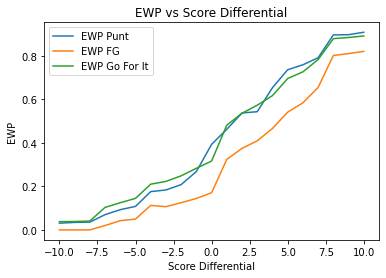

In [42]:
sweep_range = range(-10,11)
df_sweep = sweep_state(base_states[11], sweep_var='score_differential', sweep_values=sweep_range)
x = df_sweep['score_differential'].to_numpy().flatten()
y_punt = df_sweep['ewp_punt'].to_numpy().flatten()
y_fg = df_sweep['ewp_field_goal'].to_numpy().flatten()
y_go = df_sweep['ewp_go_for_it'].to_numpy().flatten()

plt.plot(x, y_punt, label='EWP Punt')
plt.plot(x, y_fg, label='EWP FG')
plt.plot(x, y_go, label='EWP Go For It')
plt.xlabel('Score Differential')
plt.ylabel('EWP')
plt.title('EWP vs Score Differential')
plt.legend()
plt.show()

Brier score: 0.16609
Reliability: 0.00003
Resolution: 0.08314
Uncertainty: 0.24999
Brier check (reliability - resolution + uncertainty): 0.16687


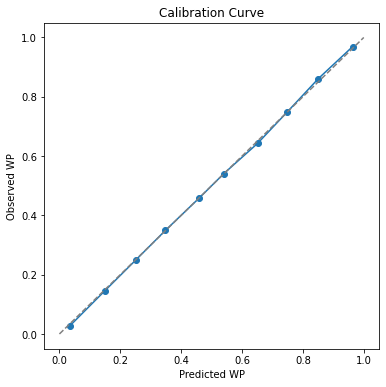

In [43]:
# ============================================================
# Step 1: Add predicted WP and actual win outcome
# ============================================================
plays_df = pbp.copy()
plays_df['wp_pred'] = predict_wp(plays_df)

# Compute final scores and win from offensive team perspective
final_scores = (
    pbp.groupby("game_id")
       .tail(1)[["game_id","home_team","away_team","home_score","away_score"]]
       .copy()
)
final_scores["home_win"] = (final_scores["home_score"] > final_scores["away_score"]).astype(int)

plays_df = plays_df.merge(final_scores[["game_id","home_win"]], on="game_id", how="left")
plays_df["win_actual"] = np.where(
    plays_df["posteam"] == plays_df["home_team"],
    plays_df["home_win"],
    1 - plays_df["home_win"]
)

# ============================================================
# Step 2: Compute calibration, Brier score, reliability/resolution
# ============================================================
# Bin predicted WP
bins = np.linspace(0, 1, 11)
wp_bin = pd.cut(plays_df['wp_pred'], bins, include_lowest=True)

# Aggregate by bin
cal_table = plays_df.groupby(wp_bin).agg(
    wp_pred_mean=('wp_pred', 'mean'),
    win_rate=('win_actual', 'mean'),
    count=('win_actual', 'count')
).reset_index()

# Brier score
brier = np.mean((plays_df['wp_pred'] - plays_df['win_actual'])**2)

# Reliability and resolution
N = len(plays_df)
reliability = np.sum(cal_table['count'] / N * (cal_table['wp_pred_mean'] - cal_table['win_rate'])**2)
resolution = np.sum(cal_table['count'] / N * (cal_table['win_rate'] - plays_df['win_actual'].mean())**2)
uncertainty = np.mean(plays_df['win_actual']) * (1 - np.mean(plays_df['win_actual']))
brier_check = reliability - resolution + uncertainty

# Print results
print(f"Brier score: {brier:.5f}")
print(f"Reliability: {reliability:.5f}")
print(f"Resolution: {resolution:.5f}")
print(f"Uncertainty: {uncertainty:.5f}")
print(f"Brier check (reliability - resolution + uncertainty): {brier_check:.5f}")

# Plot calibration
x = cal_table['wp_pred_mean'].values.ravel()  # ensures 1D
y = cal_table['win_rate'].values.ravel()     # ensures 1D

plt.figure(figsize=(6,6))
plt.plot(x, y, marker='o')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('Predicted WP')
plt.ylabel('Observed WP')
plt.title('Calibration Curve')
plt.show()

In [44]:
cal_table

,wp_pred,wp_pred_mean,win_rate,count
0,"(-0.001, 0.1]",0.034801,0.027849,43664
1,"(0.1, 0.2]",0.150068,0.146473,29077
2,"(0.2, 0.3]",0.251126,0.249693,27706
3,"(0.3, 0.4]",0.347914,0.349038,36996
4,"(0.4, 0.5]",0.458919,0.458143,53957
5,"(0.5, 0.6]",0.540503,0.541170,54469
6,"(0.6, 0.7]",0.650856,0.642548,38559
7,"(0.7, 0.8]",0.748500,0.748753,32283
8,"(0.8, 0.9]",0.851061,0.861574,29048
9,"(0.9, 1.0]",0.963586,0.969402,44023


In [45]:
pbp_pre_computed = pbp.copy()
pbp_pre_computed.loc[:, "score_time_ratio"] = (pbp_pre_computed["score_differential"].abs() / (pbp_pre_computed["game_seconds_remaining"] + 1))
pbp_pre_computed['scoring_possessions_to_tie'] = scoring_possessions_to_tie(pbp_pre_computed['score_differential'])
pbp_pre_computed['possessions_to_tie_boost'] = 0.1 / np.maximum(1, pbp_pre_computed['scoring_possessions_to_tie'])
pbp_pre_computed['wp_current'] = predict_wp(pbp_pre_computed[wp_features])
pbp_pre_computed['penalty'] = go_for_it_success_penalty(pbp_pre_computed['ydstogo'], pbp_pre_computed['wp_current'], pbp_pre_computed['game_seconds_remaining'], alpha=.035, c=3.5)

In [46]:
pbp_pre_computed['fg_success_yardline_100'] = 75
pbp_pre_computed['fg_success_down'] = 1
pbp_pre_computed['fg_success_ydstogo'] = 10
pbp_pre_computed['fg_success_game_seconds_remaining'] = np.maximum(0, pbp_pre_computed['game_seconds_remaining'] - 5)
pbp_pre_computed['fg_success_half_seconds_remaining'] = np.maximum(0, pbp_pre_computed['half_seconds_remaining'] - 5)
pbp_pre_computed['fg_success_score_differential'] = -(pbp_pre_computed['score_differential'] + 3)
pbp_pre_computed['fg_success_posteam_timeouts_remaining'] = pbp_pre_computed['defteam_timeouts_remaining']
pbp_pre_computed['fg_success_defteam_timeouts_remaining'] = pbp_pre_computed['posteam_timeouts_remaining']
pbp_pre_computed['fg_success_score_time_ratio'] = pbp_pre_computed['fg_success_score_differential'].abs() / (pbp_pre_computed['fg_success_game_seconds_remaining'] + 1)
pbp_pre_computed['fg_success_temp_F'] = pbp_pre_computed['temp_F']
pbp_pre_computed['fg_success_wind_mph'] = pbp_pre_computed['wind_mph']

pbp_pre_computed['fg_fail_yardline_100'] = 100 - (pbp_pre_computed['yardline_100'] + 7)
pbp_pre_computed['fg_fail_down'] = 1
pbp_pre_computed['fg_fail_ydstogo'] = 10
pbp_pre_computed['fg_fail_game_seconds_remaining'] = np.maximum(0, pbp_pre_computed['game_seconds_remaining'] - 5)
pbp_pre_computed['fg_fail_half_seconds_remaining'] = np.maximum(0, pbp_pre_computed['half_seconds_remaining'] - 5)
pbp_pre_computed['fg_fail_score_differential'] = -pbp_pre_computed['score_differential']
pbp_pre_computed['fg_fail_posteam_timeouts_remaining'] = pbp_pre_computed['defteam_timeouts_remaining']
pbp_pre_computed['fg_fail_defteam_timeouts_remaining'] = pbp_pre_computed['posteam_timeouts_remaining']
pbp_pre_computed['fg_fail_score_time_ratio'] = pbp_pre_computed['fg_fail_score_differential'].abs() / (pbp_pre_computed['fg_fail_game_seconds_remaining'] + 1)
pbp_pre_computed['fg_fail_temp_F'] = pbp_pre_computed['temp_F']
pbp_pre_computed['fg_fail_wind_mph'] = pbp_pre_computed['wind_mph']

pbp_pre_computed['go_success_yardline_100'] = pbp_pre_computed['yardline_100'] - pbp_pre_computed['ydstogo']
pbp_pre_computed['go_success_down'] = 1
pbp_pre_computed['go_success_ydstogo'] = np.minimum(10, pbp_pre_computed['go_success_yardline_100'])
pbp_pre_computed['go_success_game_seconds_remaining'] = np.maximum(0, pbp_pre_computed['game_seconds_remaining'] - 5)
pbp_pre_computed['go_success_half_seconds_remaining'] = np.maximum(0, pbp_pre_computed['half_seconds_remaining'] - 5)
pbp_pre_computed['go_success_score_differential'] = pbp_pre_computed['score_differential']
pbp_pre_computed['go_success_posteam_timeouts_remaining'] = pbp_pre_computed['posteam_timeouts_remaining']
pbp_pre_computed['go_success_defteam_timeouts_remaining'] = pbp_pre_computed['defteam_timeouts_remaining']
pbp_pre_computed['go_success_score_time_ratio'] = pbp_pre_computed['go_success_score_differential'].abs() / (pbp_pre_computed['go_success_game_seconds_remaining'] + 1)
pbp_pre_computed['go_success_temp_F'] = pbp_pre_computed['temp_F']
pbp_pre_computed['go_success_wind_mph'] = pbp_pre_computed['wind_mph']

pbp_pre_computed['go_fail_yardline_100'] = 100 - pbp_pre_computed['yardline_100']
pbp_pre_computed['go_fail_down'] = 1
pbp_pre_computed['go_fail_ydstogo'] = 10
pbp_pre_computed['go_fail_game_seconds_remaining'] = np.maximum(0, pbp_pre_computed['game_seconds_remaining'] - 5)
pbp_pre_computed['go_fail_half_seconds_remaining'] = np.maximum(0, pbp_pre_computed['half_seconds_remaining'] - 5)
pbp_pre_computed['go_fail_score_differential'] = -pbp_pre_computed['score_differential']
pbp_pre_computed['go_fail_posteam_timeouts_remaining'] = pbp_pre_computed['defteam_timeouts_remaining']
pbp_pre_computed['go_fail_defteam_timeouts_remaining'] = pbp_pre_computed['posteam_timeouts_remaining']
pbp_pre_computed['go_fail_score_time_ratio'] = pbp_pre_computed['go_fail_score_differential'].abs() / (pbp_pre_computed['go_fail_game_seconds_remaining'] + 1)
pbp_pre_computed['go_fail_temp_F'] = pbp_pre_computed['temp_F']
pbp_pre_computed['go_fail_wind_mph'] = pbp_pre_computed['wind_mph']

In [47]:
# FG-eligible plays (yardline known, 4th down)
fg_mask = (
    (pbp_pre_computed["down"] == 4) &
    pbp_pre_computed["yardline_100"].notna()
)

X_fg_success = pbp_pre_computed.loc[fg_mask, [
    "fg_success_yardline_100",
    "fg_success_down",
    "fg_success_ydstogo",
    "fg_success_game_seconds_remaining",
    "fg_success_half_seconds_remaining",
    "fg_success_score_differential",
    "fg_success_posteam_timeouts_remaining",
    "fg_success_defteam_timeouts_remaining",
    "fg_success_score_time_ratio",
    "fg_success_temp_F",
    "fg_success_wind_mph"
]].copy()

X_fg_success.columns = wp_features

X_fg_fail = pbp_pre_computed.loc[fg_mask, [
    "fg_fail_yardline_100",
    "fg_fail_down",
    "fg_fail_ydstogo",
    "fg_fail_game_seconds_remaining",
    "fg_fail_half_seconds_remaining",
    "fg_fail_score_differential",
    "fg_fail_posteam_timeouts_remaining",
    "fg_fail_defteam_timeouts_remaining",
    "fg_fail_score_time_ratio",
    "fg_fail_temp_F",
    "fg_fail_wind_mph"
]].copy()

X_fg_fail.columns = wp_features

In [48]:
wp_fg_success = 1 - predict_wp(X_fg_success)
wp_fg_fail = 1 - predict_wp(X_fg_fail)

# Predict FG make probability using current state
X_fg_current = pbp_pre_computed.loc[fg_mask, fg_features]
p_make = fg_final_model.predict_proba(X_fg_current)[:, 1]
yardlines = X_fg_current['yardline_100']
decay_threshold = 55
p_make_decayed = np.where(yardlines >= (decay_threshold - 17), p_make * np.maximum(0, (53 - yardlines) / (70 - decay_threshold)), p_make)

# Compute expected WP for FG attempt
ewp_fg = np.full(len(pbp_pre_computed), np.nan)
ewp_fg[fg_mask] = p_make * wp_fg_success + (1 - p_make_decayed) * wp_fg_fail

# Save to DataFrame
pbp_pre_computed["ewp_fg"] = ewp_fg
pbp_pre_computed["p_make_fg"] = 0
pbp_pre_computed.loc[fg_mask, "p_make_fg"] = p_make_decayed

In [49]:
# FG-eligible plays (yardline known, 4th down)
go_mask = (
    (pbp_pre_computed["down"] == 4) &
    pbp_pre_computed["yardline_100"].notna()
)

X_go_success = pbp_pre_computed.loc[go_mask, [
    "go_success_yardline_100",
    "go_success_down",
    "go_success_ydstogo",
    "go_success_game_seconds_remaining",
    "go_success_half_seconds_remaining",
    "go_success_score_differential",
    "go_success_posteam_timeouts_remaining",
    "go_success_defteam_timeouts_remaining",
    "go_success_score_time_ratio",
    "go_success_temp_F",
    "go_success_wind_mph"
]].copy()

X_go_success.columns = wp_features

X_go_fail = pbp_pre_computed.loc[go_mask, [
    "go_fail_yardline_100",
    "go_fail_down",
    "go_fail_ydstogo",
    "go_fail_game_seconds_remaining",
    "go_fail_half_seconds_remaining",
    "go_fail_score_differential",
    "go_fail_posteam_timeouts_remaining",
    "go_fail_defteam_timeouts_remaining",
    "go_fail_score_time_ratio",
    "go_fail_temp_F",
    "go_fail_wind_mph"
]].copy()

X_go_fail.columns = wp_features

In [50]:
masked_discrete_possessions_boost = pbp_pre_computed.loc[go_mask, "possessions_to_tie_boost"]
wp_go_success = predict_wp(X_go_success)
wp_go_success = np.clip(wp_go_success + masked_discrete_possessions_boost, 0, 1)
wp_go_fail = 1 - predict_wp(X_go_fail)

# Predict FG make probability using current state
X_go_current = pbp_pre_computed.loc[go_mask, go_features]
p_convert = conv_model.predict_proba(X_go_current)[:, 1]

# Compute expected WP for FG attempt
ewp_go = np.full(len(pbp_pre_computed), np.nan)
ewp_go[go_mask] = p_convert * wp_go_success + (1 - p_convert) * wp_go_fail

# Save to DataFrame
pbp_pre_computed["ewp_go"] = ewp_go
pbp_pre_computed['ewp_go_adj'] = np.clip(pbp_pre_computed['ewp_go'] - pbp_pre_computed['penalty'], 0, 1)
pbp_pre_computed["p_convert"] = 0
pbp_pre_computed.loc[go_mask, "p_convert"] = p_convert

In [51]:
punt_mask = (
    (pbp_pre_computed["down"] == 4) &
    pbp_pre_computed["yardline_100"].notna()
)

X_punt_current = pbp_pre_computed.loc[punt_mask, punt_features]

# 1. Pandas → numpy
X_punt_np = X_punt_current.values.astype(np.float32)

# 2. Scale inputs
X_punt_np_scaled = X_scaler.transform(X_punt_np)

# 3. numpy → torch
X_punt_tensor = torch.tensor(X_punt_np_scaled, dtype=torch.float32)

# 4. Predict (scaled output)
punt_model.eval()
with torch.no_grad():
    y_scaled_pred = punt_model(X_punt_tensor).squeeze().cpu().numpy()

# 5. Inverse transform target
punt_pred_yards = y_scaler.inverse_transform(
    y_scaled_pred.reshape(-1, 1)
).ravel()

punt_preds = np.zeros(len(pbp_pre_computed))
punt_preds[punt_mask] = punt_pred_yards

In [52]:
pbp_pre_computed['punt_pred_yards'] = punt_preds
 
landing_kicking = pbp_pre_computed['yardline_100'] - pbp_pre_computed['punt_pred_yards']
landing_kicking = np.where(landing_kicking < 0, 20, landing_kicking)  # Only clip beyond goal line
pbp_pre_computed['post_punt_yardline_100'] = 100 - landing_kicking # Flip possession

pbp_pre_computed['post_punt_down'] = 1
pbp_pre_computed['post_punt_ydstogo'] = 10
pbp_pre_computed['post_punt_game_seconds_remaining'] = np.maximum(0, pbp_pre_computed['game_seconds_remaining'] - 8)
pbp_pre_computed['post_punt_half_seconds_remaining'] = np.maximum(0, pbp_pre_computed['half_seconds_remaining'] - 8)
pbp_pre_computed['post_punt_score_differential'] = -pbp_pre_computed['score_differential']
pbp_pre_computed['post_punt_posteam_timeouts_remaining'] = pbp_pre_computed['defteam_timeouts_remaining']
pbp_pre_computed['post_punt_defteam_timeouts_remaining'] = pbp_pre_computed['posteam_timeouts_remaining']
pbp_pre_computed['post_punt_score_time_ratio'] = pbp_pre_computed['post_punt_score_differential'].abs() / (pbp_pre_computed['post_punt_game_seconds_remaining'] + 1)
pbp_pre_computed['post_punt_temp_F'] = pbp_pre_computed['temp_F']
pbp_pre_computed['post_punt_wind_mph'] = pbp_pre_computed['wind_mph']

In [53]:
X_post_punt = pbp_pre_computed.loc[punt_mask, [
    "post_punt_yardline_100",
    "post_punt_down",
    "post_punt_ydstogo",
    "post_punt_game_seconds_remaining",
    "post_punt_half_seconds_remaining",
    "post_punt_score_differential",
    "post_punt_posteam_timeouts_remaining",
    "post_punt_defteam_timeouts_remaining",
    "post_punt_score_time_ratio",
    "post_punt_temp_F",
    "post_punt_wind_mph"
]].copy()

X_post_punt.columns = wp_features

In [54]:
wp_post_punt = 1 - predict_wp(X_post_punt)

# Compute expected WP for FG attempt
ewp_punt = np.full(len(pbp_pre_computed), np.nan)
ewp_punt[punt_mask] = wp_post_punt

# Save to DataFrame
pbp_pre_computed["ewp_punt"] = ewp_punt

In [59]:
pbp_4 = pbp_pre_computed[pbp_pre_computed.down == 4]
pbp_4.sample(5)

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,post_punt_ydstogo,post_punt_game_seconds_remaining,post_punt_half_seconds_remaining,post_punt_score_differential,post_punt_posteam_timeouts_remaining,post_punt_defteam_timeouts_remaining,post_punt_score_time_ratio,post_punt_temp_F,post_punt_wind_mph,ewp_punt
243754,5335.0,2020_03_CIN_PHI,NaN,PHI,CIN,REG,3,PHI,home,CIN,...,10,11.0,11.0,-0.0,0.0,0.0,0.000000,76.0,5.0,0.610956
311202,453.0,2021_10_SEA_GB,NaN,GB,SEA,REG,10,GB,home,SEA,...,10,3069.0,1269.0,-0.0,3.0,3.0,0.000000,35.0,12.0,0.490573
209386,3589.0,2019_08_CIN_LA,NaN,LA,CIN,REG,8,CIN,away,LA,...,10,437.0,437.0,14.0,3.0,2.0,0.031963,48.0,5.0,0.026872
270711,997.0,2020_13_NE_LAC,NaN,LAC,NE,REG,13,LAC,home,NE,...,10,2543.0,743.0,14.0,3.0,3.0,0.005503,70.0,6.0,0.134147
145849,918.0,2018_01_WAS_ARI,NaN,ARI,WAS,REG,1,ARI,home,WAS,...,10,2599.0,799.0,7.0,2.0,3.0,0.002692,60.0,0.0,0.255180


In [60]:
a = pbp_4[(pbp_4.game_seconds_remaining > 1800) & (pbp_4.score_differential.abs() < 8) & ((pbp_4.yardline_100 - 50).abs() < 46)]

In [61]:
a.groupby('ydstogo')['p_convert'].mean()

ydstogo
1.0     0.427964
2.0     0.353773
3.0     0.327442
4.0     0.311166
5.0     0.311492
6.0     0.311437
7.0     0.311345
8.0     0.310762
9.0     0.310849
10.0    0.311535
11.0    0.311434
12.0    0.311391
13.0    0.311342
14.0    0.310178
15.0    0.310862
16.0    0.310494
17.0    0.310504
18.0    0.311409
19.0    0.310199
20.0    0.310832
21.0    0.308156
22.0    0.311473
23.0    0.311631
24.0    0.313342
25.0    0.310860
26.0    0.311821
27.0    0.305298
28.0    0.309843
29.0    0.308906
30.0    0.315159
31.0    0.314384
32.0    0.311411
33.0    0.314688
34.0    0.303804
35.0    0.302653
41.0    0.294287
Name: p_convert, dtype: float64

In [71]:
go_df[(go_df['ydstogo'] == 1) & (go_df['yardline_100'] <= 10)].success.mean()


0.5913757700205339